## reference :
https://www.ecmwf.int/sites/default/files/elibrary/2014/9054-semi-lagrangian-technique-atmospheric-modelling-current-status-and-future-challenges.pdf

In [12]:
import numpy as np
import matplotlib.pyplot as plt

## grid definition :

In [85]:
n = 300
lh = 0.15

x,y = np.linspace(0,1,n),np.linspace(0,1,n)
X,Y = np.meshgrid(x,y)
XX,YY = np.meshgrid(range(n),range(n))

## Defining a stationnary wind field and an initial condition

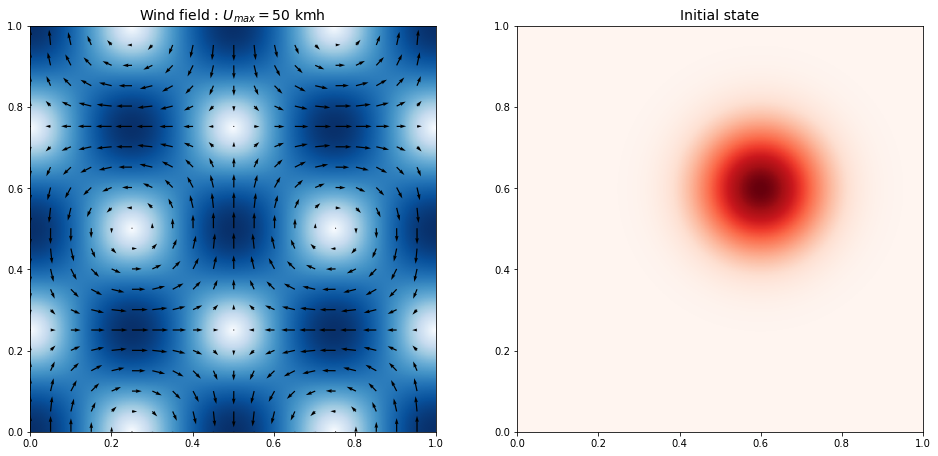

In [93]:
X0 = np.exp( - np.linalg.norm(np.array([X-0.6,Y-0.4]),axis=0)**2/lh**2)

from matplotlib import colors, cm
ex, ey = np.eye(2)
wind_x = np.sin(2*np.pi*X)*np.sin(2*np.pi*Y)
wind_y = np.cos(2*np.pi*X)*np.cos(2*np.pi*Y)

wind = np.array([wind_x,wind_y])
wind_x = wind[0][np.newaxis].T  * ex
wind_y= wind[1][np.newaxis].T* ey



D = 1000 #km
wind = wind / np.linalg.norm(wind,axis=0).max()
max_wind_velocity = 50 #kmh
wind = wind * max_wind_velocity / D


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,2,1)
length = .05


strength = np.linalg.norm(wind,axis=0)
norm=colors.Normalize(vmin = np.min(strength),
                      vmax = np.max(strength), clip = False)


ax.set_title(r"Wind field : $U_{max} = 50$ kmh ",fontsize=14)
mm = 15
ax.quiver(X[::mm,::mm],Y[::mm,::mm],wind[0][::mm,::mm], wind[1][::mm,::mm])
surface = ax.imshow(np.flip(strength,axis=1).T,extent=[0,1,0,1],cmap=cm.Blues) 

ax2 = fig.add_subplot(1,2,2)
ax2.set_title("Initial state",fontsize=14)
ax2.imshow(X0,extent=[0,1,0,1],cmap=cm.Reds);

## defining the Semi-Lagrangian class : 

In [87]:
from mypackage.problem import Model

class SemiLag2DAdv(Model):
    def _make_trend(self):
        self.wind, self.interpolation_method = self.trend_parameters
        self.n = self.wind[0].shape[0]
        self.X,self.Y = np.meshgrid(np.linspace(0,1,self.n),np.linspace(0,1,self.n))
        self.XX,self.YY = np.meshgrid(range(n),range(n))
        
        self.XXd = self.XX - self.dt * self.wind[0]*self.n
        self.YYd = self.YY - self.dt * self.wind[1]*self.n
        
        
    def _step(self, new_dt=None):
        self.x = self.interpolation_method(self.XXd,self.YYd,self.x)
        #saving :
        self.t += self.dt
        if self.save and (self.time_saving_interval =="all"  or self.t - self.last_saved_time >= self.time_saving_interval) :
            self.saved_times.append(self.t)
            self.trajectory[self.t] = self.x
            self.last_saved_time = self.t

## some interpolation methods :

In [72]:
## Nearest_neighbours :
def NN(Xd,Yd, state):
    state = state.T
    n = Xd.shape[0]
    Xd = (np.round((Xd%n))%n).astype(int)
    Yd = (np.round((Yd%n))%n).astype(int)
    interpolation = state[Xd,Yd]
    return interpolation
    

# bilinear interpolation :    
def Bilinear(Xd,Yd, state):
    n = Xd.shape[0]
    state = state.T
    Xd = Xd % n
    Yd = Yd % n
    interpolation =  (1-(Yd%1)) * ( (1-(Xd%1)) * state[Xd.astype(int),Yd.astype(int)] +
                                  (Xd%1)  * state[((Xd+1)%n).astype(int),Yd.astype(int)] ) \
               + (Yd%1)    * ( (1-(Xd%1)) * state[Xd.astype(int),((Yd+1)%n).astype(int)] +
                                  (Xd%1)  * state[((Xd+1)%n).astype(int),((Yd+1)%n).astype(int) ])
    return interpolation

## Numerical experiment : bilinear interpolation

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.73it/s]


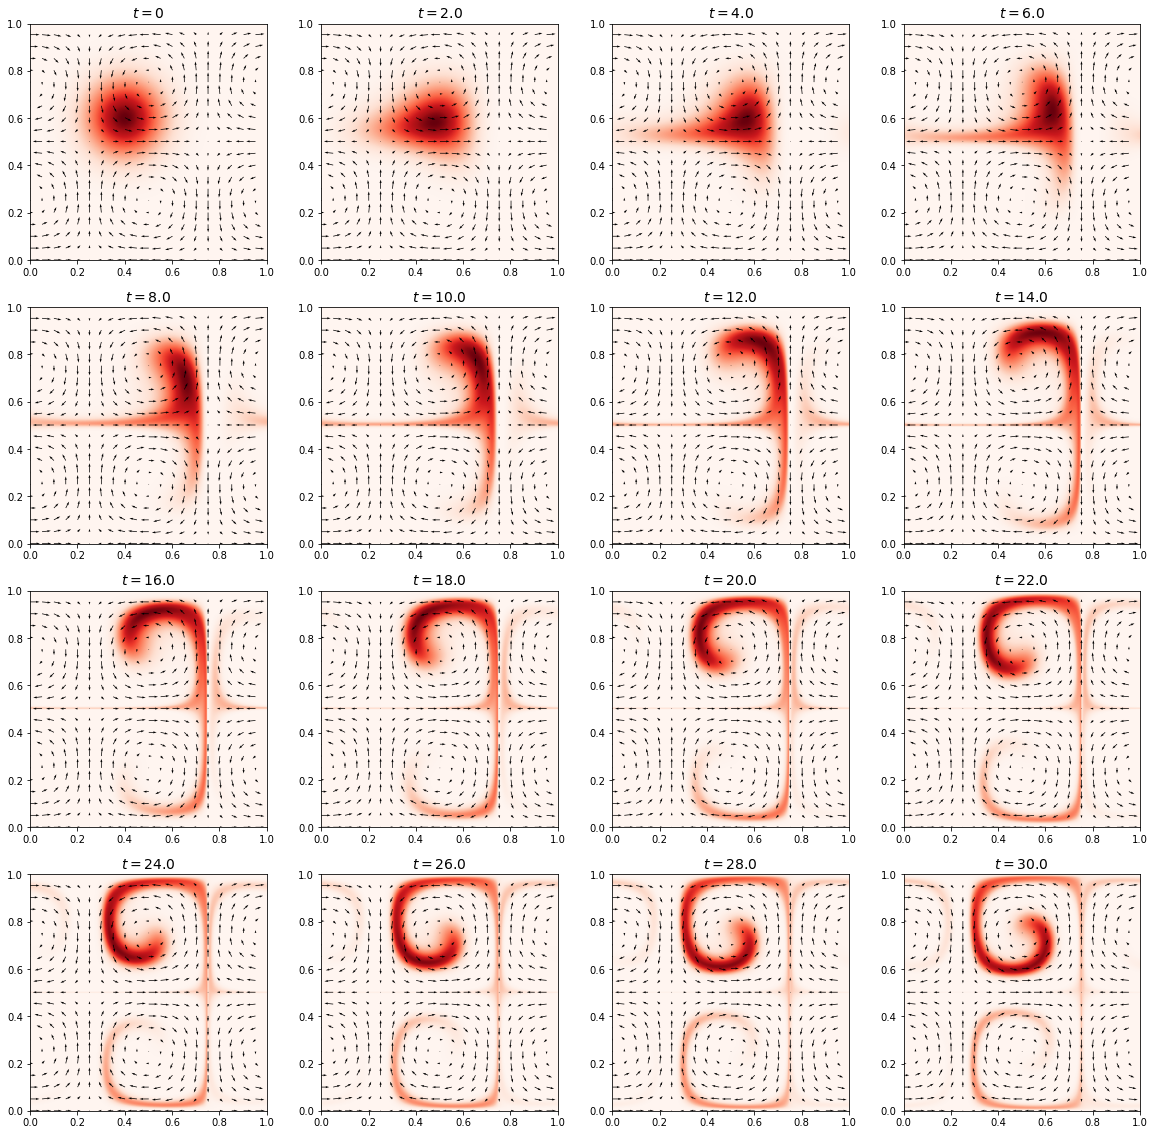

In [94]:
semilag = SemiLag2DAdv(X0, trend_parameters=[wind, Bilinear],dt=0.25,time_saving_interval=0.5)
fig, ax = plt.subplots(4,4,figsize=(20,20))
i=0
ds = int(15)
ax.flat[i].quiver(X[::ds,::ds],Y[::ds,::ds],wind[1][::ds,::ds], wind[0][::ds,::ds])
surface = ax.flat[i].imshow(np.flip(semilag.x,axis=1).T,extent=[0,1,0,1],cmap=cm.Reds,vmin=0,vmax=1) 

ax.flat[i].set_title(f"$t=${semilag.t}",fontsize=14)
    
for i in range(1,16):
    semilag.forecast(forecast_horizon=2)
    ax.flat[i].quiver(X[::ds,::ds],Y[::ds,::ds],wind[1][::ds,::ds], wind[0][::ds,::ds])
    surface = ax.flat[i].imshow(np.flip(semilag.x,axis=1).T,extent=[0,1,0,1],cmap=cm.Reds,vmin=0,vmax=1) 
    ax.flat[i].set_title(f"$t=${np.round(semilag.t,2)}",fontsize=14)
    
plt.show()

## Mass conservation :

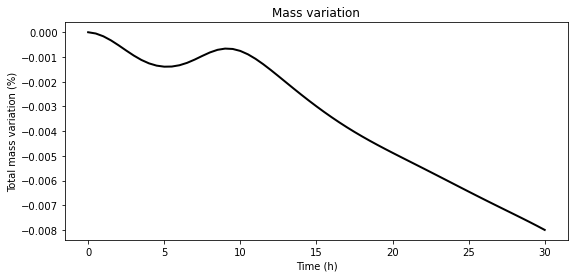

In [112]:
traj = np.array(list(semilag.trajectory.values()))
mass = traj.sum(axis=(1,2))
mass_variation = mass/mass[0] -1 
plt.figure(figsize=(9,4))
plt.plot(semilag.saved_times,mass_variation,c='k',linewidth = 2 )
plt.title("Mass variation");
plt.ylabel("Total mass variation (%)")
plt.xlabel("Time (h)");